Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


Testing 1, 2, 3

# Phase 2 Project

### Importing Data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv('Data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


#### Formatting Cell

In [2]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed

## Glossary

### Column Names and descriptions for Kings County Data Set
(source: Data/column_names.md)
* **id** - unique identified for a house
* **date** - house was sold
* **price** -  is prediction target
* **bedrooms** -  of Bedrooms/House
* **bathrooms** -  of bathrooms/bedrooms
* **sqft_livings** -  footage of the home
* **sqft_lots** -  footage of the lot
* **floors** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

### Building Condition Explaination
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#d (accessed 12/6/2021)

Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.


### Building Grade Explaination
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#d (accessed 12/6/2021)


Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

# Data Cleaning

## Dropping Uncessary Columns

In [3]:
df = df.drop(df[['id', 'date', 'view', 'lat', 'long', 'yr_renovated']], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,98074,1800,7503


## Checking Data Types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     19221 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  zipcode        21597 non-null  int64  
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.5+ MB


In [5]:
#7 records have 3.5 floors. I could drop those records, or perhaps change the value of 3.0 to "3 or more"
#df.sort_values('floors', ascending=False).head(100)

### Removing the ? in sqft_basement

In [6]:
unknown_basements = df[df['sqft_basement'] == '?']
known_basements = df[df['sqft_basement'] != '?']

print('Unkown Basement:',(len(unknown_basements)))
print('Known Basement:',(len(known_basements)))

Unkown Basement: 454
Known Basement: 21143


In [7]:
sqft_basement = unknown_basements.apply(lambda x: x['sqft_living'] - x['sqft_above'], axis=1)
unknown_basements['sqft_basement'] = sqft_basement

cleaned_df = known_basements.append(unknown_basements)

#changing to float so that decminals are in the same format
cleaned_df['sqft_basement'] = cleaned_df['sqft_basement'].astype(float)
cleaned_df['sqft_above'] = cleaned_df['sqft_above'].astype(float)

cleaned_df['sqft_basement'].value_counts().head()

<ipython-input-7-1fc1beccaa25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_basements['sqft_basement'] = sqft_basement


0.0      13110
600.0      221
700.0      218
500.0      214
800.0      206
Name: sqft_basement, dtype: int64

### Changing Zip Code to Category

In [8]:
cleaned_df['zipcode'] = df['zipcode'].astype(str)
cleaned_df['zipcode'].value_counts().head()

98103    602
98038    589
98115    583
98052    574
98117    553
Name: zipcode, dtype: int64

### Dropping Bedroom Outliers

In [9]:
#cleaned_df['bedrooms'].value_counts()

In [10]:
#dropping outliers
cleaned_df = cleaned_df.sort_values('bedrooms', ascending=False).reset_index()
cleaned_df = cleaned_df.drop([0,1,2])
cleaned_df.head(5)

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
3,19239,660000.0,10,3.00,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1913,98105,1810,3745
4,13301,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2500.0,2090.0,2008,98004,2730,10400
5,8537,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,4050.0,0.0,1996,98144,1448,3866
6,18428,934000.0,9,3.00,2820,4480,2.0,0.0,3,7,1880.0,940.0,1918,98105,2460,4400
7,4231,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,2830.0,850.0,1908,98102,1960,2450


In [11]:
#dropping index
cleaned_df = cleaned_df.drop(['index'], axis=1)

In [12]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 3 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21594 non-null  float64
 1   bedrooms       21594 non-null  int64  
 2   bathrooms      21594 non-null  float64
 3   sqft_living    21594 non-null  int64  
 4   sqft_lot       21594 non-null  int64  
 5   floors         21594 non-null  float64
 6   waterfront     19218 non-null  float64
 7   condition      21594 non-null  int64  
 8   grade          21594 non-null  int64  
 9   sqft_above     21594 non-null  float64
 10  sqft_basement  21594 non-null  float64
 11  yr_built       21594 non-null  int64  
 12  zipcode        21594 non-null  object 
 13  sqft_living15  21594 non-null  int64  
 14  sqft_lot15     21594 non-null  int64  
dtypes: float64(6), int64(8), object(1)
memory usage: 2.6+ MB


### Exploring Data with Scatter Plot

In [13]:
#using scatter plot to look for linear relationships
#pd.plotting.scatter_matrix(cleaned_df, figsize = [20,20]);
#plt.show()

### Analysis:
At first glance, the following variables seem to have linear relationships:
- price with bedrooms, sqft_above, & sqft_basement.
    - price also seems to have a linear relationship with categorical variable 'grade'.
- bedrooms with bathrooms, sqft_living, sqft_above, & sqft_basement
- sqft_living and sqft_above have the closest linear relationship
    - They are very similar data points. I may need to eliminate one to prevent multicolinearity.
    
The Following Variables seem to be categorical:
- floors
- waterfront
- condition
- zip code (not shown because I have already made it an object)

Ordinal Variables:
- bedrooms
- bathrooms



### What To Do with the Ordinal Values

I am going to treat grade as a continuous variable as it has very linear relationships with many features. Including price.

## Checking for Null Values

In [14]:
cleaned_df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
sqft_living15       0
sqft_lot15          0
dtype: int64

## Fixing Waterfront

In [15]:
#cleaned_df['waterfront'].value_counts()

In [16]:
waterfront_cleaned = cleaned_df['waterfront'].fillna(0) 
cleaned_df['waterfront'] = waterfront_cleaned
cleaned_df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Building Condition

Should I change the condition values from numbers to words?

## Bedrooms

Should I change bedrooms so that there are less options? ie, <1 instead of 0, 0.5, etc

# Exploratory Data Analysis

In [17]:
cleaned_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15
count,2.159400e+04,21594.000000,21594.000000,21594.000000,2.159400e+04,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000
mean,5.402878e+05,3.371168,2.115808,2080.229740,1.510045e+04,1.494072,0.006761,3.409743,7.658007,1788.546633,291.683106,1971.003844,1986.674493,12759.056914
std,3.673922e+05,0.901536,0.769010,918.084207,4.141540e+04,0.539688,0.081950,0.650482,1.173256,827.749396,442.684260,29.374473,685.252555,27276.229189
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.619000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068475e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,2360.000000,10082.250000
max,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,6210.000000,871200.000000


In [18]:
#cleaned_df.hist(figsize = (20,18));

In [19]:
#sns.jointplot('bedrooms','price', data=cleaned_df, kind='reg');

In [20]:
# Slight Linearity?

In [21]:
#sns.jointplot('bathrooms','price', data=cleaned_df, kind='reg');

In [22]:
# Fairly Linear. Especially if I remove the outliers.

In [23]:
#sns.jointplot('sqft_living','price', data=cleaned_df, kind='reg');

In [24]:
# VERY linear relationship. Normal-ish distribution.

In [25]:
#sns.jointplot('sqft_lot','price', data=cleaned_df, kind='reg');

In [26]:
#sns.jointplot('floors','price', data=cleaned_df, kind='reg');

In [27]:
#sns.jointplot('waterfront','price', data=cleaned_df, kind='reg');

In [28]:
#sns.jointplot('condition','price', data=cleaned_df, kind='reg');

In [29]:
#interestingly, condition doesn't appear to have an affect on price.

In [30]:
#ns.jointplot('grade','price', data=cleaned_df, kind='reg');

In [31]:
#linear relationship with a little noise

In [32]:
#sns.jointplot('sqft_above','price', data=cleaned_df, kind='reg');

In [33]:
#as expected. Very linear.

In [34]:
#sns.jointplot('sqft_basement','price', data=cleaned_df, kind='reg');

In [35]:
#slight linear relationship

In [36]:
#sns.jointplot('yr_built','price', data=cleaned_df, kind='reg');

In [37]:
#no linearity

In [38]:
#sns.jointplot('sqft_living15','price', data=cleaned_df, kind='reg');

In [39]:
# fairly linear

In [40]:
#sns.jointplot('sqft_lot15','price', data=cleaned_df, kind='reg');

### Analysis of Jointplots
- As the data currently stands, sqft_living, sqft_above, and sqft_living15 are my best predictors.
- bedrooms, bathrooms, grade, sqft_lot, sqft_basement, and sqft_lot15 also show linear relationships and could possibly be improved
- condition and yr_built don't have linear relationships and therefore not much prediction power.

In [41]:
#lets go ahead and remove the features that aren't useful
cleaned_df = cleaned_df.drop(['condition', 'yr_built'], axis=1)
cleaned_df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15
3,660000.0,10,3.0,2920,3745,2.0,0.0,7,1860.0,1060.0,98105,1810,3745


In [42]:
feats = ['sqft_living', 'sqft_above', 'sqft_living15','bedrooms','bathrooms', 'grade', 'sqft_lot',
         'sqft_basement','sqft_lot15']
corr = cleaned_df[feats].corr()
corr

,sqft_living,sqft_above,sqft_living15,bedrooms,bathrooms,grade,sqft_lot,sqft_basement,sqft_lot15
sqft_living,1.000000,0.876432,0.756510,0.593994,0.755803,0.762923,0.173482,0.435114,0.184369
sqft_above,0.876432,1.000000,0.731837,0.493213,0.686700,0.756185,0.184159,-0.052206,0.195094
sqft_living15,0.756510,0.731837,1.000000,0.406011,0.569949,0.713865,0.144749,0.200510,0.183499
bedrooms,0.593994,0.493213,0.406011,1.000000,0.529021,0.367654,0.033822,0.309656,0.032107
bathrooms,0.755803,0.686700,0.569949,0.529021,1.000000,0.665890,0.088384,0.283441,0.088315
grade,0.762923,0.756185,0.713865,0.367654,0.665890,1.000000,0.114720,0.168282,0.120968
sqft_lot,0.173482,0.184159,0.144749,0.033822,0.088384,0.114720,1.000000,0.015435,0.718202
sqft_basement,0.435114,-0.052206,0.200510,0.309656,0.283441,0.168282,0.015435,1.000000,0.017570
sqft_lot15,0.184369,0.195094,0.183499,0.032107,0.088315,0.120968,0.718202,0.017570,1.000000


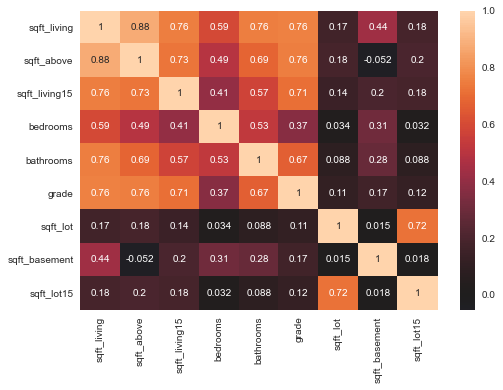

In [43]:
sns.heatmap(corr, center=0, annot=True);

# Initial Modeling 

## Version 2 - following the template in the practice Lab

In [44]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 3 to 21596
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21594 non-null  float64
 1   bedrooms       21594 non-null  int64  
 2   bathrooms      21594 non-null  float64
 3   sqft_living    21594 non-null  int64  
 4   sqft_lot       21594 non-null  int64  
 5   floors         21594 non-null  float64
 6   waterfront     21594 non-null  float64
 7   grade          21594 non-null  int64  
 8   sqft_above     21594 non-null  float64
 9   sqft_basement  21594 non-null  float64
 10  zipcode        21594 non-null  object 
 11  sqft_living15  21594 non-null  int64  
 12  sqft_lot15     21594 non-null  int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 2.3+ MB


In [45]:
list(cleaned_df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'grade',
 'sqft_above',
 'sqft_basement',
 'zipcode',
 'sqft_living15',
 'sqft_lot15']

In [46]:
# Defining the problem
outcome = 'price'
x_cols = list(cleaned_df.columns)
x_cols.remove(outcome)

In [47]:
train, test = train_test_split(cleaned_df)

#print(len(train), len(test))

In [48]:
print(len(train), len(test))
train.head()

16195 5399


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15
21466,713000.0,1,1.00,1180,4000,1.5,0.0,8,840.0,340.0,98118,1420,4000
9414,250000.0,3,1.75,1160,6134,1.0,0.0,7,1160.0,0.0,98002,1330,6301
7244,988000.0,4,3.00,4040,19700,2.0,0.0,11,4040.0,0.0,98052,3930,21887
6911,300000.0,4,2.50,2200,8065,2.0,0.0,7,2200.0,0.0,98031,2641,8535
9465,705640.0,3,2.25,2400,12350,1.0,0.0,8,1420.0,980.0,98033,2615,12043


In [49]:
test.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15
16762,628000.0,3,2.25,1720,8521,1.0,0.0,7,1140.0,580.0,98033,1530,8692
20773,221700.0,2,1.50,1556,20000,1.0,0.0,7,1556.0,0.0,98032,2250,17286
10606,387865.0,3,2.50,2370,4200,2.0,0.0,8,2370.0,0.0,98038,2370,4200
7054,450000.0,4,2.75,2980,13260,1.0,0.0,8,1800.0,1180.0,98056,1920,10731
11189,190000.0,3,1.00,1510,8760,1.0,0.0,6,1510.0,0.0,98002,1040,7828


In [50]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     771.4
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:37:08   Log-Likelihood:            -2.1758e+05
No. Observations:               16195   AIC:                         4.353e+05
Df Residuals:                   16115   BIC:                         4.359e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -4.17e+05    1.6e+04    -26.046      0.000   -4.48e+05   -3.86e+05
zipcode[T.98002]  4.941e+04   1.68e+04      2.940      0.003    1.65e+04    8.23e+04
zipcode[T.98003]  2628.4938   1.54e+04      0.171      0.864   -2.75e+04    3.28e+04
zipcode[T.98004]  7.563e+05   1.48e+04     51.155      0.000    7.27e+05    7.85e+05
zipcode[T.98005]  2.969e+05   1.77e+04     16.822      0.000    2.62e+05    3.32e+05
zipcode[T.98006]  2.807e+05   1.36e+04     20.652      0.000    2.54e+05    3.07e+05
zipcode[T.98007]  2.553e+05   1.91e+04     13.361      0.000    2.18e+05    2.93e+05
zipcode[T.98008]  2.662e+05   1.52e+04     17.476      0.000    2.36e+05    2.96e+05
zipcode[T.98010]  7.261e+04   2.14e+04      3.395      0.001    3.07e+04    1.15e+05
zipcode[T.98011]  1.164e+05    1.7e+04      6.844      0.000    8.31e+04     1.5e+05
zipcode[T.98014]  9.612e+04   1.96e+04      4.908      0.000    5.77e+04    1.35e+05
zipcode[T.98019]  8.531e+04   1.71e+04      4.993      0.000    5.18e+04    1.19e+05
zipcode[T.98022]   2.35e+04   1.61e+04      1.457      0.145   -8105.698    5.51e+04
zipcode[T.98023] -3.288e+04   1.32e+04     -2.486      0.013   -5.88e+04   -6959.066
zipcode[T.98024]  1.649e+05   2.47e+04      6.690      0.000    1.17e+05    2.13e+05
zipcode[T.98027]   1.62e+05   1.39e+04     11.666      0.000    1.35e+05    1.89e+05
zipcode[T.98028]  1.219e+05    1.5e+04      8.134      0.000    9.26e+04    1.51e+05
zipcode[T.98029]  2.057e+05   1.47e+04     13.986      0.000    1.77e+05    2.34e+05
zipcode[T.98030]  4751.7030   1.58e+04      0.300      0.764   -2.63e+04    3.58e+04
zipcode[T.98031]  1.652e+04   1.57e+04      1.049      0.294   -1.43e+04    4.74e+04
zipcode[T.98032]   1.81e+04      2e+04      0.903      0.366   -2.12e+04    5.74e+04
zipcode[T.98033]  3.793e+05   1.37e+04     27.594      0.000    3.52e+05    4.06e+05
zipcode[T.98034]  2.097e+05    1.3e+04     16.136      0.000    1.84e+05    2.35e+05
zipcode[T.98038]  2.489e+04   1.28e+04      1.940      0.052    -251.700       5e+04
zipcode[T.98039]  1.291e+06   2.93e+04     44.119      0.000    1.23e+06    1.35e+06
zipcode[T.98040]  5.457e+05   1.53e+04     35.582      0.000    5.16e+05    5.76e+05
zipcode[T.98042]  4565.3321   1.29e+04      0.353      0.724   -2.08e+04    2.99e+04
zipcode[T.98045]  8.881e+04   1.64e+04      5.426      0.000    5.67e+04    1.21e+05
zipcode[T.98052]  2.156e+05    1.3e+04     16.625      0.000     1.9e+05    2.41e+05
zipcode[T.98053]  1.637e+05   1.41e+04     11.642      0.000    1.36e+05    1.91e+05
zipcode[T.98055]   5.58e+04   1.56e+04      3.572      0.000    2.52e+04    8.64e+04
zipcode[T.98056]   1.17e+05   1.38e+04      8.455      0.000    8.99e+04    1.44e+05
zipcode[T.98058]  2.485e+04   1.35e+04      1.838      0.066   -1652.174    5.14e+04
zipcode[T.98059]   7.16

In [51]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

81 71
['zipcode[T.98002]', 'zipcode[T.98004]', 'zipcode[T.98005]', 'zipcode[T.98006]', 'zipcode[T.98007]']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,-4.17e+05,1.6e+04,-26.046,0.000,-4.48e+05,-3.86e+05
zipcode[T.98002],4.941e+04,1.68e+04,2.940,0.003,1.65e+04,8.23e+04
zipcode[T.98003],2628.4938,1.54e+04,0.171,0.864,-2.75e+04,3.28e+04
zipcode[T.98004],7.563e+05,1.48e+04,51.155,0.000,7.27e+05,7.85e+05
zipcode[T.98005],2.969e+05,1.77e+04,16.822,0.000,2.62e+05,3.32e+05


### Refining Model

In [52]:
#removing problem zipcodes
df_1 = cleaned_df[cleaned_df['zipcode'] == '98002']
df_2 = cleaned_df[cleaned_df['zipcode'] == '98003']
df_3 = cleaned_df[cleaned_df['zipcode'] == '98004']
df_4 = cleaned_df[cleaned_df['zipcode'] == '98005']


print('df_1:', len(df_1))
print('df_2:', len(df_2))
print('df_3:', len(df_3))
print('df_4:', len(df_4))

df_1: 199
df_2: 280
df_3: 317
df_4: 168


Removing the problem zipcodes removes 4% of the data from the data set.
- 964 records removed from 21,596

In [53]:
problem_zips = pd.concat([df_1, df_2, df_3, df_4])
problem_zips

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15
120,370000.0,6,2.75,3240,5750,1.0,0.0,6,2160.0,1080.0,98002,1230,5750
190,343000.0,6,5.00,2732,7655,2.0,0.0,7,2732.0,0.0,98002,3078,69993
253,389000.0,6,4.50,3560,14010,2.0,0.0,7,3560.0,0.0,98002,1710,11116
259,300000.0,6,3.00,2400,9373,2.0,0.0,7,2400.0,0.0,98002,2060,7316
270,300000.0,6,5.25,2860,5682,2.0,0.0,7,2860.0,0.0,98002,1390,5956
311,300000.0,6,3.00,2744,9926,2.0,0.0,7,2744.0,0.0,98002,2470,9926
321,280000.0,6,3.00,2400,9373,2.0,0.0,7,2400.0,0.0,98002,2060,7316
327,260000.0,6,2.00,2220,8797,1.0,0.0,7,2220.0,0.0,98002,1170,5123
360,250750.0,5,1.75,2140,12058,1.0,0.0,8,2140.0,0.0,98002,1640,10125
602,319450.0,5,2.00,2250,5472,1.5,0.0,7,1750.0,500.0,98002,1540,5472


In [54]:
cleaned_df['zipcode'].value_counts().head()

98103    601
98038    589
98115    583
98052    574
98117    553
Name: zipcode, dtype: int64

In [55]:
new_df = cleaned_df.drop(problem_zips.index)
new_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15
3,660000.0,10,3.0,2920,3745,2.0,0.0,7,1860.0,1060.0,98105,1810,3745
5,450000.0,9,7.5,4050,6504,2.0,0.0,7,4050.0,0.0,98144,1448,3866
6,934000.0,9,3.0,2820,4480,2.0,0.0,7,1880.0,940.0,98105,2460,4400
7,700000.0,9,3.0,3680,4400,2.0,0.0,7,2830.0,850.0,98102,1960,2450
8,1400000.0,9,4.0,4620,5508,2.5,0.0,11,3870.0,750.0,98105,2710,4320
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,227000.0,1,2.0,1150,9812,1.0,0.0,7,1150.0,0.0,98001,1200,9812
21593,199900.0,1,1.0,720,7140,1.0,0.0,6,720.0,0.0,98146,1140,7577
21594,330600.0,1,1.0,580,1799,1.0,0.0,7,580.0,0.0,98117,1260,4000
21595,385195.0,1,1.0,710,6000,1.5,0.0,6,710.0,0.0,98144,1440,4800


In [56]:
#the problem zip codes have been removed so I can run my model again.
cleaned_df_2 = new_df

In [57]:
# Defining the problem
outcome = 'price'
x_cols = list(cleaned_df_2.columns)
x_cols.remove(outcome)

In [58]:
train, test = train_test_split(cleaned_df_2)

In [59]:
print(len(train), len(test))
train.head()

15472 5158


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15
2410,362000.0,4,2.50,2360,7370,1.0,0.0,7,1460.0,900.0,98125,1590,9906
12833,399000.0,3,2.25,1880,12473,1.0,0.0,8,1420.0,460.0,98028,2300,10469
10884,346500.0,3,3.25,1570,2048,2.0,0.0,8,1290.0,280.0,98126,1570,2006
3776,465000.0,4,1.75,1470,5350,1.0,0.0,7,980.0,490.0,98125,1970,6138
14112,449888.0,3,2.25,2520,78408,2.0,0.0,9,2520.0,0.0,98001,1490,29972


In [60]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     759.4
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:37:09   Log-Likelihood:            -2.0719e+05
No. Observations:               15472   AIC:                         4.145e+05
Df Residuals:                   15396   BIC:                         4.151e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.835e+05   1.56e+04    -24.589      0.000   -4.14e+05   -3.53e+05
zipcode[T.98006]  2.919e+05   1.29e+04     22.653      0.000    2.67e+05    3.17e+05
zipcode[T.98007]  2.499e+05   1.83e+04     13.632      0.000    2.14e+05    2.86e+05
zipcode[T.98008]  2.761e+05   1.46e+04     18.946      0.000    2.47e+05    3.05e+05
zipcode[T.98010]  7.976e+04   2.06e+04      3.864      0.000    3.93e+04     1.2e+05
zipcode[T.98011]  1.119e+05   1.63e+04      6.876      0.000       8e+04    1.44e+05
zipcode[T.98014]  9.525e+04   1.93e+04      4.923      0.000    5.73e+04    1.33e+05
zipcode[T.98019]  7.075e+04   1.67e+04      4.239      0.000     3.8e+04    1.03e+05
zipcode[T.98022]  3.892e+04   1.58e+04      2.464      0.014    7963.191    6.99e+04
zipcode[T.98023] -3.085e+04   1.27e+04     -2.437      0.015   -5.57e+04   -6031.569
zipcode[T.98024]  1.821e+05   2.25e+04      8.088      0.000    1.38e+05    2.26e+05
zipcode[T.98027]  1.647e+05   1.35e+04     12.201      0.000    1.38e+05    1.91e+05
zipcode[T.98028]  1.172e+05   1.46e+04      8.008      0.000    8.85e+04    1.46e+05
zipcode[T.98029]  2.106e+05   1.41e+04     14.942      0.000    1.83e+05    2.38e+05
zipcode[T.98030]  4904.2270   1.53e+04      0.321      0.748    -2.5e+04    3.48e+04
zipcode[T.98031]  1.209e+04   1.45e+04      0.832      0.405   -1.64e+04    4.06e+04
zipcode[T.98032]   2.61e+04   1.95e+04      1.342      0.180    -1.2e+04    6.42e+04
zipcode[T.98033]  3.881e+05   1.31e+04     29.705      0.000    3.62e+05    4.14e+05
zipcode[T.98034]  2.109e+05   1.25e+04     16.832      0.000    1.86e+05    2.35e+05
zipcode[T.98038]  2.092e+04   1.24e+04      1.691      0.091   -3327.661    4.52e+04
zipcode[T.98039]  1.353e+06   2.74e+04     49.302      0.000     1.3e+06    1.41e+06
zipcode[T.98040]  5.365e+05   1.47e+04     36.398      0.000    5.08e+05    5.65e+05
zipcode[T.98042]  8958.2431   1.25e+04      0.717      0.473   -1.55e+04    3.34e+04
zipcode[T.98045]  9.382e+04   1.56e+04      6.004      0.000    6.32e+04    1.24e+05
zipcode[T.98052]  2.179e+05   1.24e+04     17.528      0.000    1.93e+05    2.42e+05
zipcode[T.98053]  1.732e+05   1.37e+04     12.660      0.000    1.46e+05       2e+05
zipcode[T.98055]  5.672e+04   1.48e+04      3.822      0.000    2.76e+04    8.58e+04
zipcode[T.98056]  1.081e+05   1.33e+04      8.120      0.000     8.2e+04    1.34e+05
zipcode[T.98058]  2.932e+04   1.31e+04      2.243      0.025    3701.542    5.49e+04
zipcode[T.98059]  7.864e+04    1.3e+04      6.032      0.000    5.31e+04    1.04e+05
zipcode[T.98065]   8.44e+04   1.47e+04      5.761      0.000    5.57e+04    1.13e+05
zipcode[T.98070]  2.753e+04      2e+04      1.375      0.169   -1.17e+04    6.68e+04
zipcode[T.98072]  1.419e+05   1.48e+04      9.570      0.000    1.13e+05    1.71e+05
zipcode[T.98074]  1.667

### Cleaning & Encoding

In [61]:
#dropping sqft_lot15 because of it's p-value
encoded_df = cleaned_df_2.drop(cleaned_df_2[['sqft_lot15']], axis=1)
encoded_df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15
3,660000.0,10,3.0,2920,3745,2.0,0.0,7,1860.0,1060.0,98105,1810


In [62]:
subs = [(' ', '_'),('.',''),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

In [63]:
encoded_df.columns = [col_formatting(col) for col in encoded_df.columns]

In [64]:
list(encoded_df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'grade',
 'sqft_above',
 'sqft_basement',
 'zipcode',
 'sqft_living15']

In [65]:
#one-hot encoding
#feats = ['bedrooms','floors', 'waterfront','zipcode']
feats = ['floors', 'waterfront','zipcode'] #treating bedrooms as a continous variable helps the model
#feats = ['zipcode']
encoded_df[feats] = encoded_df[feats].astype(str)
encoded_df = pd.get_dummies(encoded_df, drop_first=True)

In [66]:
#encoded_df.info()

In [67]:
encoded_df.columns = [col_formatting(col) for col in encoded_df.columns]

In [68]:
list(encoded_df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'floors_15',
 'floors_20',
 'floors_25',
 'floors_30',
 'floors_35',
 'waterfront_10',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98055',
 'zipcode_98056',
 'zipcode_98058',
 'zipcode_98059',
 'zipcode_98065',
 'zipcode_98070',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode_98075',
 'zipcode_98077',
 'zipcode_98092',
 'zipcode_98102',
 'zipcode_98103',
 'zipcode_98105',
 'zipcode_98106',
 'zipcode_98107',
 'zipcode_98108',
 'zipcode_98109',
 'zipcode_9

### Normalizing Data

In [69]:
def norm_feat(series):
    return (series - series.mean())/series.std()

In [70]:
#cleaned_df_2.info()

In [71]:
df_norm = norm_feat(encoded_df)
df_norm.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,sqft_living15,floors_15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,0.370957,7.376789,1.161134,0.937494,-0.271343,-0.555952,0.097239,1.759819,-0.246962,-0.314785,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
5,-0.236883,6.265752,7.035782,2.182665,-0.206136,-0.555952,2.761899,-0.660074,-0.779851,-0.314785,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
6,1.164043,6.265752,1.161134,0.827302,-0.253972,-0.555952,0.121574,1.485869,0.709881,-0.314785,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
7,0.486736,6.265752,1.161134,1.774954,-0.255863,-0.555952,1.277477,1.280406,-0.026152,-0.314785,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
8,2.512868,6.265752,2.466612,2.810759,-0.229676,2.884919,2.542886,1.052115,1.077898,-0.314785,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492


### Checking Multicolinearity with VIF scores

In [72]:
x_cols = list(df_norm.columns)
x_cols.remove(outcome)

In [73]:
X = df_norm[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


[('bedrooms', 1.767995155353305),
 ('bathrooms', 3.127254257135732),
 ('sqft_living', inf),
 ('sqft_lot', 1.2186913238842705),
 ('grade', 3.451994717418607),
 ('sqft_above', inf),
 ('sqft_basement', inf),
 ('sqft_living15', 3.173677007957456),
 ('floors_15', 1.2762929702230283),
 ('floors_20', 2.4502137326704814),
 ('floors_25', 1.111616061239859),
 ('floors_30', 1.3765044740321324),
 ('floors_35', 1.0083626268124972),
 ('waterfront_10', 1.0622416912027839),
 ('zipcode_98006', 2.417090428153525),
 ('zipcode_98007', 1.387784555122681),
 ('zipcode_98008', 1.7757752946164533),
 ('zipcode_98010', 1.2777402318750353),
 ('zipcode_98011', 1.5319451395150299),
 ('zipcode_98014', 1.3652862065115932),
 ('zipcode_98019', 1.523245866855921),
 ('zipcode_98022', 1.655967543847793),
 ('zipcode_98023', 2.3325100515302557),
 ('zipcode_98024', 1.2383854104321252),
 ('zipcode_98027', 2.129488749851739),
 ('zipcode_98028', 1.7648588658038151),
 ('zipcode_98029', 1.8958031762658767),
 ('zipcode_98030', 1.6

### Using old method to find colinear pairs

In [74]:
cc_df = df_norm.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.70) & (cc_df.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.876288
"(grade, sqft_living)",0.758073
"(sqft_living, sqft_living15)",0.757909
"(bathrooms, sqft_living)",0.753509
"(grade, sqft_above)",0.752714
"(sqft_living15, sqft_above)",0.737170
"(grade, sqft_living15)",0.710891


Analysis: sqft_living is causing a lot of multicollinearity. Dropping it will resolve most of the issues. I will also drop grade as it is so highly correlated to sqft_above, which is going to be one of my most important predictors.
- I am also dropping sqft_living15.

In [75]:
df_norm = df_norm.drop(['sqft_living', 'grade', 'sqft_living15'], axis=1)
#df_norm = df_norm.drop(['sqft_living15'], axis=1)
df_norm.head(1)

,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,0.370957,7.376789,1.161134,-0.271343,0.097239,1.759819,-0.314785,1.265219,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492


In [76]:
cc_df = df_norm.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.70) & (cc_df.cc<1)]

,cc
pairs,


That took care of the correlated pairs. Now let's check the vif scores again and see if it resolved the infinite correlations.

In [77]:
x_cols = list(df_norm.columns)
x_cols.remove(outcome)

In [78]:
X = df_norm[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.724308799038663),
 ('bathrooms', 3.056643751413851),
 ('sqft_lot', 1.2184973229356937),
 ('sqft_above', 3.1122183566501227),
 ('sqft_basement', 1.8043481858439907),
 ('floors_15', 1.270236332729379),
 ('floors_20', 2.425769872904832),
 ('floors_25', 1.1081910900844425),
 ('floors_30', 1.3464886616689333),
 ('floors_35', 1.0079668187020585),
 ('waterfront_10', 1.0610960021215228),
 ('zipcode_98006', 2.36359596567367),
 ('zipcode_98007', 1.3833914423764082),
 ('zipcode_98008', 1.7719799499725872),
 ('zipcode_98010', 1.2773800273267122),
 ('zipcode_98011', 1.5280327710171713),
 ('zipcode_98014', 1.3647641846389995),
 ('zipcode_98019', 1.521230137051646),
 ('zipcode_98022', 1.6558428201265247),
 ('zipcode_98023', 2.3282296084347234),
 ('zipcode_98024', 1.2380202501351325),
 ('zipcode_98027', 2.118739278896308),
 ('zipcode_98028', 1.7620223592295654),
 ('zipcode_98029', 1.8859993631714689),
 ('zipcode_98030', 1.6889484447407392),
 ('zipcode_98031', 1.7343291346567908),
 ('zi

I am happy with these VIF scores. There is still a decent correlation between sqft_above and bathrooms, but it is within the limits that I have set, and they are two predictors that I want to keep if at all possible.

### Running the model again

In [79]:
# Defining the problem
outcome = 'price'
x_cols = list(df_norm.columns)
x_cols.remove(outcome)

In [80]:
train, test = train_test_split(df_norm)

In [81]:
print(len(train), len(test))
train.head()

15472 5158


,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
5284,-0.714472,0.710568,0.508396,-0.186142,-0.413791,1.440211,-0.314785,-0.790339,-0.088408,-0.173960,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
10810,-0.323717,-0.400469,0.182026,-0.334446,-0.292117,-0.477440,-0.314785,-0.790339,-0.088408,5.748156,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
7790,-0.048742,0.710568,-0.470712,-0.171252,-0.060937,-0.660074,-0.314785,-0.790339,-0.088408,-0.173960,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
18652,-0.823593,-1.511506,-0.144343,-0.333430,-0.900487,-0.431782,-0.314785,1.265219,-0.088408,-0.173960,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
11376,0.067037,-0.400469,-1.449820,-0.251372,-0.985659,-0.020857,3.176619,-0.790339,-0.088408,-0.173960,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492


In [82]:
test.head()

,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
2298,-0.208083,0.710568,-0.144343,0.147454,0.413592,0.800994,-0.314785,-0.790339,-0.088408,-0.173960,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
13571,-0.440944,-0.400469,0.182026,-0.024343,0.352755,-0.660074,-0.314785,1.265219,-0.088408,-0.173960,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
12926,-0.439496,-0.400469,0.508396,-0.317831,-0.206946,-0.660074,-0.314785,-0.790339,-0.088408,5.748156,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
15674,-0.016903,-0.400469,0.182026,0.067901,-0.644972,1.052115,-0.314785,-0.790339,-0.088408,-0.173960,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
4036,0.776183,0.710568,0.508396,0.072722,1.362648,-0.660074,-0.314785,1.265219,-0.088408,-0.173960,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492


In [83]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     715.3
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:38:26   Log-Likelihood:                -10068.
No. Observations:               15472   AIC:                         2.029e+04
Df Residuals:                   15395   BIC:                         2.088e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0010      0.004     -0.259      0.796      -0.008       0.006
bedrooms         -0.0919      0.005    -18.654      0.000      -0.102      -0.082
bathrooms         0.0650      0.007      9.901      0.000       0.052       0.078
sqft_lot          0.0355      0.004      8.494      0.000       0.027       0.044
sqft_above        0.6286      0.007     95.422      0.000       0.616       0.641
sqft_basement     0.2328      0.005     46.165      0.000       0.223       0.243
floors_15        -0.0137      0.004     -3.239      0.001      -0.022      -0.005
floors_20        -0.0798      0.006    -13.714      0.000      -0.091      -0.068
floors_25         0.0149      0.004      3.872      0.000       0.007       0.022
floors_30        -0.0480      0.004    -10.911      0.000      -0.057      -0.039
floors_35         0.0071      0.004      1.658      0.097      -0.001       0.016
waterfront_10     0.2098      0.004     55.743      0.000       0.202       0.217
zipcode_98006     0.1563      0.006     27.395      0.000       0.145       0.168
zipcode_98007     0.0707      0.004     16.291      0.000       0.062       0.079
zipcode_98008     0.0978      0.005     19.991      0.000       0.088       0.107
zipcode_98010     0.0127      0.004      3.070      0.002       0.005       0.021
zipcode_98011     0.0398      0.005      8.650      0.000       0.031       0.049
zipcode_98014     0.0170      0.004      3.824      0.000       0.008       0.026
zipcode_98019     0.0197      0.005      4.362      0.000       0.011       0.029
zipcode_98022     0.0073      0.005      1.536      0.125      -0.002       0.017
zipcode_98023    -0.0065      0.006     -1.160      0.246      -0.018       0.005
zipcode_98024     0.0290      0.004      6.779      0.000       0.021       0.037
zipcode_98027     0.0747      0.005     13.851      0.000       0.064       0.085
zipcode_98028     0.0453      0.005      9.162      0.000       0.036       0.055
zipcode_98029     0.0880      0.005     17.329      0.000       0.078       0.098
zipcode_98030     0.0026      0.005      0.548      0.584      -0.007       0.012
zipcode_98031     0.0076      0.005      1.574      0.116      -0.002       0.017
zipcode_98032     0.0057      0.004      1.349      0.177      -0.003       0.014
zipcode_98033     0.1626      0.005     30.146      0.000       0.152       0.173
zipcode_98034     0.1025      0.006     17.620      0.000       0.091       0.114
zipcode_98038     0.0116      0.006      1.960      0.050   -1.09e-06       0.023
zipcode_98039     0.1825      0.004     46.456      0.000       0.175       0.190
zipcode_98040     0.2029      0.005     41.107      0.000       0.193       0.213
zipcode_98042     0.0070      0.006      1.208      0.227      -0.004       0.018
zipcode_98045     0.0297      0.005      6.327   

Model Analysis: 
- R2 is 78.5%. I would ideally like to see it at 80% or above, but this is very close.
- Prob(F-statistic) is 0, which means that there is good model integrity.
- Kurtosis is still really high. I will need to refine it so that it is closer to normal (3)
- Model is skewed. Still need to fix that.

# Checking Assumptions

## Checking Normality

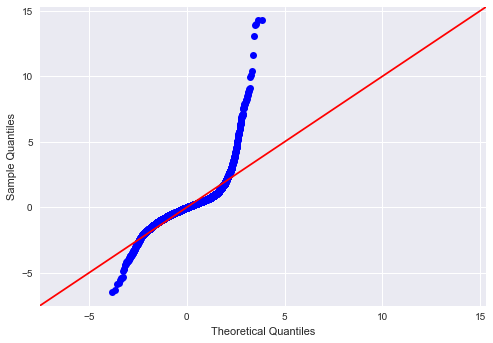

In [84]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

There are more errors as price increases. This needs to be refined so that the model is accurate. This model cannot be used without further refinement.

## Checking Homoscedasticity 

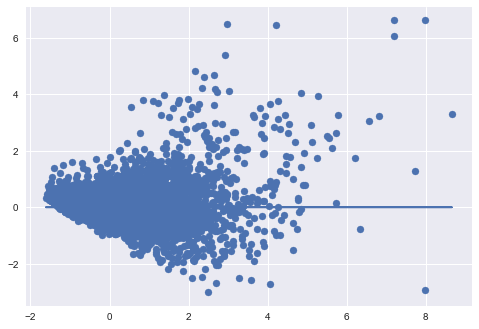

In [85]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

Funnel-shaped. Need to correct.

## Dealing with Outliers

I want to switch back to encoded_df so that I can see what the acutal price is, instead of the normalized price. I will drop the same columns that I dropped from df_norm so that they contain the same data.

In [86]:
encoded_df = encoded_df.drop(['sqft_living', 'grade', 'sqft_living15'], axis=1)
#encoded_df = encoded_df.drop(['sqft_living', 'grade'], axis=1)
encoded_df.head(1)

,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,660000.0,10,3.0,3745,1860.0,1060.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

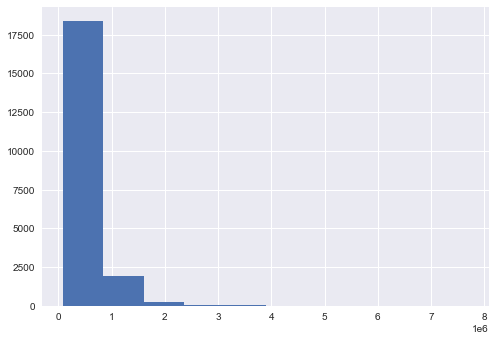

In [87]:
encoded_df.price.hist()

In [88]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, encoded_df.price.quantile(q=q)))

0.8 percentile: 690000.0
0.81 percentile: 701490.0000000016
0.82 percentile: 718000.0
0.83 percentile: 731127.9999999999
0.84 percentile: 750000.0
0.85 percentile: 761649.9999999979
0.86 percentile: 780000.0
0.87 percentile: 799268.9999999999
0.88 percentile: 818000.0
0.89 percentile: 840000.0
0.9 percentile: 862000.0
0.91 percentile: 890302.6399999995
0.92 percentile: 925000.0
0.93 percentile: 963990.0
0.94 percentile: 1010000.0
0.95 percentile: 1100000.0
0.96 percentile: 1200000.0
0.97 percentile: 1310000.0
0.98 percentile: 1500000.0
0.99 percentile: 1880000.0


In [89]:
for i in range(0,20):
    q = i/100
    print("{} percentile: {}".format(q, encoded_df.price.quantile(q=q)))

0.0 percentile: 78000.0
0.01 percentile: 155000.0
0.02 percentile: 178000.0
0.03 percentile: 195000.0
0.04 percentile: 205000.0
0.05 percentile: 214972.5
0.06 percentile: 222000.0
0.07 percentile: 230000.0
0.08 percentile: 236159.99999999994
0.09 percentile: 244000.0
0.1 percentile: 249950.0
0.11 percentile: 254000.0
0.12 percentile: 260000.0
0.13 percentile: 265000.0
0.14 percentile: 270000.0
0.15 percentile: 275000.0
0.16 percentile: 280000.0
0.17 percentile: 285000.0
0.18 percentile: 290000.0
0.19 percentile: 295500.0


In [90]:
df = encoded_df

orig_tot = len(df)
df = df[df.price < 1500000]# Subsetting to remove extreme outliers
df = df[df.price > 149000]
print('Percent removed:', (orig_tot -len(df))/orig_tot)
df.price = df.price.map(np.log) # Applying a log transformation
train, test = train_test_split(df)

# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
final_model = ols(formula=formula, data=train).fit()
final_model.summary()


Percent removed: 0.027775084827920505


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     865.0
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:59:33   Log-Likelihood:                 3232.9
No. Observations:               15042   AIC:                            -6312.
Df Residuals:                   14965   BIC:                            -5725.
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.8497      0.014    831.450      0.000      11.822      11.878
bedrooms         -0.0226      0.002     -9.601      0.000      -0.027      -0.018
bathrooms         0.0527      0.004     14.311      0.000       0.045       0.060
sqft_lot       7.189e-07   4.21e-08     17.062      0.000    6.36e-07    8.01e-07
sqft_above        0.0003   3.66e-06     91.981      0.000       0.000       0.000
sqft_basement     0.0002   5.08e-06     47.193      0.000       0.000       0.000
floors_15         0.0161      0.006      2.563      0.010       0.004       0.028
floors_20        -0.0273      0.005     -5.273      0.000      -0.037      -0.017
floors_25        -0.0438      0.022     -2.027      0.043      -0.086      -0.001
floors_30        -0.1215      0.011    -11.047      0.000      -0.143      -0.100
floors_35        -0.1127      0.080     -1.404      0.160      -0.270       0.045
waterfront_10     0.6636      0.025     26.083      0.000       0.614       0.713
zipcode_98006     0.7296      0.016     44.967      0.000       0.698       0.761
zipcode_98007     0.7080      0.024     29.909      0.000       0.662       0.754
zipcode_98008     0.7042      0.018     38.888      0.000       0.669       0.740
zipcode_98010     0.2411      0.025      9.523      0.000       0.192       0.291
zipcode_98011     0.4683      0.020     23.332      0.000       0.429       0.508
zipcode_98014     0.2549      0.024     10.422      0.000       0.207       0.303
zipcode_98019     0.2982      0.021     14.069      0.000       0.257       0.340
zipcode_98022     0.0824      0.019      4.242      0.000       0.044       0.120
zipcode_98023    -0.0045      0.016     -0.281      0.779      -0.036       0.027
zipcode_98024     0.3903      0.029     13.234      0.000       0.332       0.448
zipcode_98027     0.5484      0.017     32.750      0.000       0.516       0.581
zipcode_98028     0.4300      0.018     23.467      0.000       0.394       0.466
zipcode_98029     0.6320      0.018     35.374      0.000       0.597       0.667
zipcode_98030     0.0472      0.019      2.484      0.013       0.010       0.084
zipcode_98031     0.0750      0.018      4.102      0.000       0.039       0.111
zipcode_98032     0.0004      0.024      0.016      0.987      -0.047       0.048
zipcode_98033     0.8179      0.017     49.032      0.000       0.785       0.851
zipcode_98034     0.5367      0.016     34.079      0.000       0.506       0.568
zipcode_98038     0.1505      0.016      9.708      0.000       0.120       0.181
zipcode_98039     1.3469      0.058     23.288      0.000       1.233       1.460
zipcode_98040     0.9729      0.019     49.919      0.000       0.935       1.011
zipcode_98042     0.0592      0.016      3.758      0.000       0.028       0.090
zipcode_98045     0.3164      0.019     16.354   

Model Analysis: Removing some of the price outliers on each end improved the model. (R2 is now at 83%)
- This only removed 2.7% of the data, which is acceptable.

In [91]:
#making sure the changes are saved as final_df
final_df = df
final_df.head()

,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,13.399995,10,3.0,3745,1860.0,1060.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,13.017003,9,7.5,6504,4050.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,13.747232,9,3.0,4480,1880.0,940.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,13.458836,9,3.0,4400,2830.0,850.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,14.151983,9,4.0,5508,3870.0,750.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

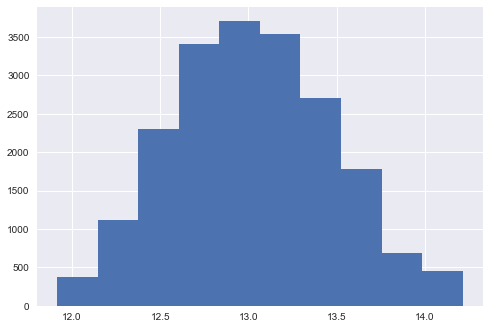

In [92]:
final_df.price.hist()

This histogram now looks to have a normal distribution. This is a good sign.

## Normalizing final_df and running model on it

In [93]:
final_df.describe()

,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,20057.000000,20057.000000,20057.000000,2.005700e+04,20057.000000,20057.000000,20057.000000,20057.000000,20057.000000,20057.000000,...,20057.000000,20057.000000,20057.000000,20057.000000,20057.000000,20057.000000,20057.000000,20057.000000,20057.000000,20057.000000
mean,13.022591,3.351149,2.088560,1.490613e+04,1748.478038,279.377773,0.091340,0.381114,0.006531,0.029167,...,0.013412,0.002742,0.021987,0.012215,0.012415,0.012115,0.012664,0.006581,0.013511,0.015107
std,0.453431,0.888416,0.728591,4.086124e+04,763.915758,421.243313,0.288099,0.485673,0.080555,0.168278,...,0.115033,0.052295,0.146646,0.109848,0.110730,0.109404,0.111822,0.080859,0.115454,0.121981
min,11.915052,1.000000,0.500000,5.200000e+02,370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.691580,3.000000,1.500000,5.000000e+03,1190.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.014778,3.000000,2.250000,7.480000e+03,1540.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.337475,4.000000,2.500000,1.035000e+04,2160.000000,540.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,14.214287,10.000000,7.500000,1.651359e+06,7320.000000,2850.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [94]:
final_df_norm = norm_feat(final_df)
final_df_norm.head()

,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,0.832330,7.483939,1.250962,-0.273147,0.145987,1.853139,-0.317043,1.274287,-0.081080,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846
5,-0.012325,6.358340,7.427264,-0.205626,3.012796,-0.663222,-0.317043,1.274287,-0.081080,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846
6,1.598129,6.358340,1.250962,-0.255159,0.172168,1.568268,-0.317043,1.274287,-0.081080,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846
7,0.962097,6.358340,1.250962,-0.257117,1.415761,1.354614,-0.317043,1.274287,-0.081080,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846
8,2.490771,6.358340,2.623473,-0.230001,2.777167,1.117222,-0.317043,-0.784714,12.332854,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846


In [95]:
# Defining the problem
outcome = 'price'
x_cols = list(final_df_norm.columns)
x_cols.remove(outcome)

In [96]:
train, test = train_test_split(final_df_norm)

In [97]:
print(len(train), len(test))
train.head()

15042 5015


,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
18743,-0.730014,-1.520852,-1.494061,-0.239986,-1.202329,-0.663222,-0.317043,-0.784714,-0.08108,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846
16435,0.315002,-0.395253,-0.464678,-0.159225,-0.456173,0.120173,-0.317043,-0.784714,-0.08108,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846
7256,1.364191,0.730346,1.937218,0.617526,1.428851,-0.663222,-0.317043,-0.784714,-0.08108,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846
6620,2.490771,0.730346,1.594090,-0.140626,1.009957,4.511934,-0.317043,-0.784714,-0.08108,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846
12241,-1.856594,-0.395253,-0.464678,-0.129172,-0.796525,-0.663222,-0.317043,-0.784714,-0.08108,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846


In [98]:
test.head()

,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
18117,0.698491,-0.395253,0.221578,-0.175353,0.564882,-0.663222,-0.317043,1.274287,-0.08108,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846
12223,-0.370746,-0.395253,-0.121550,-0.211867,-0.783435,-0.663222,-0.317043,-0.784714,-0.08108,-0.173325,...,-0.116591,-0.052437,6.669221,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846
14615,1.256589,-0.395253,0.221578,-0.254670,-0.168184,-0.663222,-0.317043,1.274287,-0.08108,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846
5372,-0.798939,0.730346,-0.121550,-0.260788,-0.704892,-0.663222,-0.317043,-0.784714,-0.08108,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846
7044,0.543560,0.730346,0.907834,-0.124351,1.926288,-0.663222,-0.317043,1.274287,-0.08108,-0.173325,...,-0.116591,-0.052437,-0.149935,-0.111201,-0.112116,-0.11074,-0.113251,-0.081391,-0.117029,-0.123846


In [99]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     867.9
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        16:06:49   Log-Likelihood:                -8714.5
No. Observations:               15042   AIC:                         1.758e+04
Df Residuals:                   14965   BIC:                         1.817e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0005      0.004      0.154      0.878      -0.006       0.007
bedrooms         -0.0430      0.005     -9.249      0.000      -0.052      -0.034
bathrooms         0.0760      0.006     12.723      0.000       0.064       0.088
sqft_lot          0.0656      0.004     17.018      0.000       0.058       0.073
sqft_above        0.5732      0.006     92.758      0.000       0.561       0.585
sqft_basement     0.2248      0.005     47.515      0.000       0.216       0.234
floors_15         0.0097      0.004      2.406      0.016       0.002       0.018
floors_20        -0.0214      0.006     -3.837      0.000      -0.032      -0.010
floors_25        -0.0061      0.004     -1.695      0.090      -0.013       0.001
floors_30        -0.0433      0.004    -10.513      0.000      -0.051      -0.035
floors_35        -0.0028      0.003     -0.845      0.398      -0.009       0.004
waterfront_10     0.0864      0.004     24.248      0.000       0.079       0.093
zipcode_98006     0.2409      0.005     45.508      0.000       0.231       0.251
zipcode_98007     0.1260      0.004     30.013      0.000       0.118       0.134
zipcode_98008     0.1816      0.005     39.523      0.000       0.173       0.191
zipcode_98010     0.0356      0.004      8.990      0.000       0.028       0.043
zipcode_98011     0.1016      0.004     23.433      0.000       0.093       0.110
zipcode_98014     0.0415      0.004     10.414      0.000       0.034       0.049
zipcode_98019     0.0635      0.004     14.434      0.000       0.055       0.072
zipcode_98022     0.0157      0.004      3.515      0.000       0.007       0.024
zipcode_98023    -0.0029      0.005     -0.545      0.586      -0.013       0.008
zipcode_98024     0.0543      0.004     14.019      0.000       0.047       0.062
zipcode_98027     0.1633      0.005     32.017      0.000       0.153       0.173
zipcode_98028     0.1128      0.005     23.891      0.000       0.104       0.122
zipcode_98029     0.1724      0.005     35.992      0.000       0.163       0.182
zipcode_98030     0.0123      0.005      2.693      0.007       0.003       0.021
zipcode_98031     0.0203      0.005      4.395      0.000       0.011       0.029
zipcode_98032     0.0014      0.004      0.343      0.732      -0.007       0.009
zipcode_98033     0.2521      0.005     49.796      0.000       0.242       0.262
zipcode_98034     0.1925      0.005     35.265      0.000       0.182       0.203
zipcode_98038     0.0542      0.006      9.620      0.000       0.043       0.065
zipcode_98039     0.0776      0.004     21.304      0.000       0.070       0.085
zipcode_98040     0.2238      0.004     50.425      0.000       0.215       0.232
zipcode_98042     0.0237      0.005      4.353      0.000       0.013       0.034
zipcode_98045     0.0762      0.004     16.950   

## Checking Assumptions Again

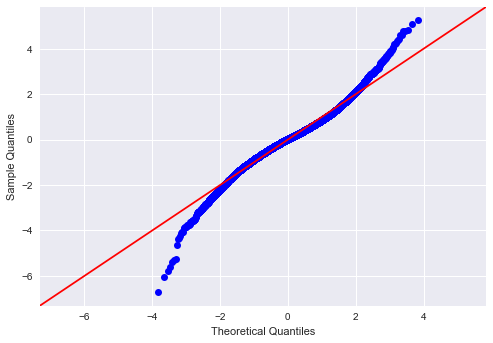

In [100]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

Normality is definitely improved, but isn't where it should be yet. 

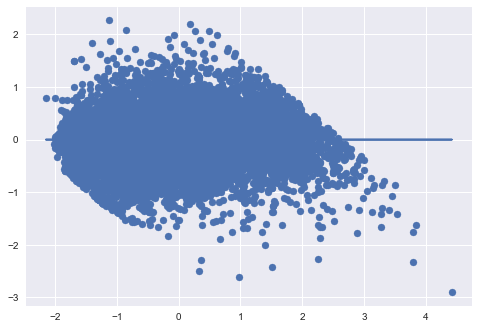

In [101]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

Homoscedasity: Also improved, but still not fully looking like it needs to.

If I attempt to remove more outliers from price, the model R2 score drops, and there is no difference with the assumption checks. I will need to refine other variables to improve my model.

## Checking Mulitcolinearity

In [102]:
x_cols = list(final_df_norm.columns)
x_cols.remove(outcome)

X = final_df_norm[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.7328243041571305),
 ('bathrooms', 2.8349439580192457),
 ('sqft_lot', 1.2098932690166946),
 ('sqft_above', 3.068105537219317),
 ('sqft_basement', 1.7981490997003626),
 ('floors_15', 1.2810541128175401),
 ('floors_20', 2.487858735421117),
 ('floors_25', 1.0788268888518528),
 ('floors_30', 1.3558056223042179),
 ('floors_35', 1.0080749507911997),
 ('waterfront_10', 1.0667107688260196),
 ('zipcode_98006', 2.288489084807606),
 ('zipcode_98007', 1.3918952347509748),
 ('zipcode_98008', 1.7627835763650432),
 ('zipcode_98010', 1.2815302748703354),
 ('zipcode_98011', 1.5399710922021774),
 ('zipcode_98014', 1.3566953607644823),
 ('zipcode_98019', 1.530546468274073),
 ('zipcode_98022', 1.6701318291746994),
 ('zipcode_98023', 2.3259610467874676),
 ('zipcode_98024', 1.2188271184995731),
 ('zipcode_98027', 2.1189137948989094),
 ('zipcode_98028', 1.7762422782105314),
 ('zipcode_98029', 1.896811357101835),
 ('zipcode_98030', 1.693374195139756),
 ('zipcode_98031', 1.7478690365379626),
 ('

# Alternative Approach: Building from the Ground Up

In [103]:
alt_df = encoded_df[['price', 'sqft_above', 'bedrooms', 'bathrooms', 'sqft_basement']]
alt_df

,price,sqft_above,bedrooms,bathrooms,sqft_basement
3,660000.0,1860.0,10,3.0,1060.0
5,450000.0,4050.0,9,7.5,0.0
6,934000.0,1880.0,9,3.0,940.0
7,700000.0,2830.0,9,3.0,850.0
8,1400000.0,3870.0,9,4.0,750.0
...,...,...,...,...,...
21592,227000.0,1150.0,1,2.0,0.0
21593,199900.0,720.0,1,1.0,0.0
21594,330600.0,580.0,1,1.0,0.0
21595,385195.0,710.0,1,1.0,0.0


In [104]:
x_cols = ['price', 'sqft_above', 'bedrooms', 'bathrooms', 'sqft_basement']

In [105]:
train, test = train_test_split(alt_df)

print(len(train), len(test))

15472 5158


In [106]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
alt_model = ols(formula=formula, data=train).fit()
alt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.365e+32
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        16:11:12   Log-Likelihood:             2.9136e+05
No. Observations:               15472   AIC:                        -5.827e+05
Df Residuals:                   15466   BIC:                        -5.827e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.082e-09   5.28e-11     20.479      0.000    9.79e-10    1.19e-09
price             1.0000   5.42e-17   1.84e+16      0.000       1.000       1.000
sqft_above    -1.679e-13   2.86e-14     -5.862      0.000   -2.24e-13   -1.12e-13
bedrooms       8.936e-11   1.84e-11      4.847      0.000    5.32e-11    1.25e-10
bathrooms      1.064e-10    2.6e-11      4.093      0.000    5.54e-11    1.57e-10
sqft_basement -2.558e-13   3.82e-14     -6.692      0.000   -3.31e-13   -1.81e-13
==============================================================================
Omnibus:                    11937.888   Durbin-Watson:                   0.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           664411.181
Skew:                          -3.229   Prob(JB):                         0.00
Kurtosis:                      34.447   Cond. No.                     2.67e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [107]:
x_cols = list(alt_df.columns)
x_cols.remove(outcome)

In [108]:
X = alt_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('sqft_above', 13.33084627314011),
 ('bedrooms', 12.599039184071668),
 ('bathrooms', 18.999678465548744),
 ('sqft_basement', 1.880097447172962)]

In [109]:
alt_df = alt_df.drop(['bathrooms'], axis=1)

In [110]:
x_cols = ['price', 'sqft_above', 'bedrooms', 'sqft_basement']

In [111]:
x_cols = list(alt_df.columns)
x_cols.remove(outcome)

In [112]:
X = alt_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('sqft_above', 7.99602565564019),
 ('bedrooms', 9.5811163287823),
 ('sqft_basement', 1.6691774042658896)]

In [ ]:
fig = sm.graphics.qqplot(alt_model.resid, dist=stats.norm, line='45', fit=True)

In [ ]:
plt.scatter(alt_model.predict(train[x_cols]), alt_model.resid)
plt.plot(alt_model.predict(train[x_cols]), [0 for i in range(len(train))])

Maybe I should drop bedrooms. They can be covered in my outcome as just "extra square feet added to the house". A bathroom is a more unique feature that I would like to capture.
- The normality assumption looks great now, but the model is still not homoscedastic.
- Let me check multicolinear pairs before dropping anything...

## normalizing and re-running

In [ ]:
alt_df_norm = norm_feat(alt_df)
alt_df_norm.head()

In [ ]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
alt_model = ols(formula=formula, data=train).fit()
alt_model.summary()

In [ ]:
cc_df = alt_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.5) & (cc_df.cc<1)]

It appears that bathrooms are the bigger problem.

In [ ]:
#removing bathrooms to see what happens.
alt_df = alt_df.drop(['bathrooms'], axis=1)
alt_df.head()

In [ ]:
x_cols = ['sqft_above', 'bedrooms', 'sqft_basement']

In [ ]:
#checking VIF again to see what effect removing bedrooms had.
X = alt_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))1

In [ ]:
cc_df = alt_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.6) & (cc_df.cc<1)]

In [ ]:
#removing bedrooms to see what happens.
alt_df = alt_df.drop(['bedrooms'], axis=1)
alt_df.head()

In [ ]:
x_cols = ['sqft_above', 'bathrooms', 'sqft_basement']

In [ ]:
#checking VIF again to see what effect removing bedrooms had.
X = alt_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

That didn't make much of a difference. 

# Taking what I learned back to the old model
- I am going to try dropping bathrooms and/or bedrooms from the old model to see if it fixes some of my issues.

In [ ]:
df_norm.head()

In [ ]:
df_norm = df_norm.drop(['bathrooms'], axis=1)
df_norm.head(1)

In [ ]:
train, test = train_test_split(df_norm)

In [ ]:
print(len(train), len(test))
train.head()

In [ ]:
x_cols = list(df_norm.columns)
x_cols.remove(outcome)

In [ ]:
X = df_norm[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

In [ ]:
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

# Archive

## Baseline Model (Version 1)
- running a model with the cleaned data.

In [ ]:
# drop zipcode before running base model
base_df = cleaned_df
base_df = base_df.drop(base_df[['zipcode']], axis=1)
base_df.head()

In [ ]:
X = base_df.drop(['price'], axis=1)
y = base_df['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

### Baseline Normalization

In [ ]:
def norm_feat(series):
    return (series - series.mean())/series.std()

In [ ]:
df_base_norm = norm_feat(base_df)
df_base_norm.head()

In [ ]:
X = df_base_norm.drop('price', axis=1)
y = df_base_norm['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

### Checking for Multicolinearity

In [ ]:
#numeric variables
numeric_vars= ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

#numeric_vars= ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront',
#'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
numeric_vars

In [ ]:
cleaned_df.head(1)

In [ ]:
num_var_df = cleaned_df.loc[:,numeric_vars]
num_var_df.head()

In [ ]:
#scatter matrix for numeric variables
#pd.plotting.scatter_matrix(king_preprocessed, figsize=[20, 20]);

In [ ]:
#correlation matrix
num_var_df.corr()

In [ ]:
#abs(king_preprocessed.corr()) > 0.75

In [ ]:
cc_df = num_var_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.75) & (cc_df.cc<1)]

I need to remove some of these variables to prevent multicolineartiy. 


### Multicollinearity Analysis

There are 5 sets of variables that are highly correlated.  

In [ ]:
#removing these two variables removes all of the colinearity pairs
#king_preprocessed.drop(columns=['sqft_above', 'sqft_living'], inplace=True)

In [ ]:
num_var_df.head(1)

In [ ]:
col_test_df = num_var_df
col_test_df

In [ ]:
col_test_df = col_test_df.drop(columns=['grade', 'sqft_living'], axis=1)
col_test_df.head(1)

In [ ]:
cc_df = col_test_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.75) & (cc_df.cc<1)]

## Check VIF Scores!!!!

In [ ]:
#def variance_inflation_factors(exog_df):
#    exog_df = add_constant(exog_df)
#    vifs = pd.Series(
#        [1 / (1. - OLS(exog_df[col].values, 
#                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
#         for col in exog_df],
#        index=exog_df.columns,
#        name='VIF'
#    )
#    return vifs

## Model #2

## Make Changes to Model HERE!

In [ ]:
cleaned_df.head(1)

In [ ]:
# drop more columns?
changed_df = cleaned_df
changed_df = changed_df.drop(changed_df[['grade', 'sqft_above']], axis=1)
#changed_df.head()

In [ ]:
model_2 = changed_df
model_2.head(1)

In [ ]:
#one-hot encoding
#feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
#feats = ['bedrooms','waterfront', 'condition']
#changed_df[feats] = changed_df[feats].astype(str)
#changed_df = pd.get_dummies(changed_df, drop_first=True)

In [ ]:
#for Model 2 I am encoding waterfront and zipcode
#feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
feats = ['waterfront', 'zipcode']
model_2[feats] = model_2[feats].astype(str)
model_2 = pd.get_dummies(model_2, drop_first=True)
model_2.head()

## Run Model #2

In [ ]:
#df_norm.head()
test_df = model_2

In [ ]:
X = test_df.drop('price', axis=1)
y = test_df['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()X = test_df.drop('price', axis=1)
y = test_df['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

### Model #2 Normalized

In [ ]:
model_2_norm = norm_feat(model_2)
model_2_norm.head()

In [ ]:
X = model_2_norm.drop('price', axis=1)
y = model_2_norm['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

## Model #3
- model 3 has all of the features encoded.

In [ ]:
model_3 = changed_df
model_3.head()

In [ ]:
feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
model_3[feats] = model_3[feats].astype(str)
model_3 = pd.get_dummies(model_3, drop_first=True)
model_3.head()

In [ ]:
#df_norm.head()
X = model_3.drop('price', axis=1)
y = model_3['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

In [ ]:
#sns.pairplot(test_df)

In [ ]:
#sns.heatmap(king_preprocessed);

In [ ]:
king_preprocessed.head(1)

## One-Hot Encoding

In [ ]:
#feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
feats = ['bedrooms','waterfront', 'condition']
cleaned_df[feats] = cleaned_df[feats].astype(str)
cleaned_df = pd.get_dummies(cleaned_df, drop_first=True)

## Modeling

In [ ]:
#df['waterfront'].value_counts()

In [ ]:
#df['waterfront'] = df['waterfront'].astype('bool') #converting waterfront into boolean

## Resetting IDs to make them shorter

In [ ]:
X = test_df.drop('price', axis=1)
y = test_df['price']

## Should I drop low grade?

In [ ]:
low_grade = cleaned_df[cleaned_df['grade'] <= 5]
low_grade.head()

## Plotting Categoricals

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10), sharey=True)

for col, ax in zip(categoricals, axes.flatten()):
    (king_preprocessed.groupby(col)               # group values together by column of interest
         .mean()['price']        # take the mean of the saleprice for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()


In [ ]:
#sns.heatmap(df_norm);

## One-Hot Encoding using Skilearn

In [ ]:
#trying sklearn method
ohe = OneHotEncoder(drop='first')

In [ ]:
data_trans = ohe.fit_transform(king_preprocessed)
data_trans.todense()

In [ ]:
data_trans = pd.DataFrame(data_trans.todense(), columns=ohe.get_feature_names())
data_trans.head()